# NgspiceX - Monte Carlo simulation example

1.0 | 22.08.2021 | jchabloz | First draft<br>
1.1 | 21.12.2021 | jchabloz | New run with NgSpice 35<br>
1.2 | 27.03.2022 | jchabloz | New run with NgSpice 36<br>
1.3 | 31.08.2022 | jchabloz | New run with NgSpice 37, use tqdm.notebook<br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#NgspiceX---Monte-Carlo-simulation-example" data-toc-modified-id="NgspiceX---Monte-Carlo-simulation-example-1">NgspiceX - Monte Carlo simulation example</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1">Introduction</a></span></li><li><span><a href="#Simulation-preparation" data-toc-modified-id="Simulation-preparation-1.2">Simulation preparation</a></span><ul class="toc-item"><li><span><a href="#Expected-results" data-toc-modified-id="Expected-results-1.2.1">Expected results</a></span></li></ul></li><li><span><a href="#Monte-Carlo-simulation-loop" data-toc-modified-id="Monte-Carlo-simulation-loop-1.3">Monte Carlo simulation loop</a></span></li><li><span><a href="#Simulation-results" data-toc-modified-id="Simulation-results-1.4">Simulation results</a></span><ul class="toc-item"><li><span><a href="#Comparison-with-expected-results" data-toc-modified-id="Comparison-with-expected-results-1.4.1">Comparison with expected results</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.5">Conclusion</a></span></li></ul></li></ul></div>

## Introduction

This notebook intends to demonstrate how to use [ngspice-connect](https://github.com/jchabloz/ngspice-connect) to run efficiently a [Monte Carlo simulation](https://www.wikiwand.com/en/Monte_Carlo_method) with [ngspice](http://ngspice.sourceforge.net/) by using Python instead of resorting to the simulator internal scripting language.

In this demo, we create a simple resistive divider circuit with the value of the resistances including some statistical variations. We distinguish a *lot (or process) variation*, that would affect the nominal value of the resistances in a similar manner for all the resistances in the circuit from a *device variation* that affects separately each resistor and that models the mismatch between them.

## Simulation preparation

The demo start by importing all the required packages and creating an instance of the ``NgSpice`` class to access the ngspice shared library.

In [1]:
from ngspicex import NgSpice
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from tqdm.notebook import tqdm
from time import perf_counter

In [2]:
ngx = NgSpice()

 ******
 ** ngspice-37 shared library
 ** Creation Date: Thu Aug 18 18:20:16 UTC 2022
 ******


We define a few parameters for the simulation:

In [3]:
V1 = 1.0            #[V]    Input voltage
sigma_R_lot = 100   #[Ohms] Standard deviation (lot)
sigma_R_dev = 200   #[Ohms] Standard deviation (device)
R = 1e4             #[Ohms] Resistances nominal value
lot = 0             #[-]    0: don't use lot variations, 1: use lot variations
dev = 1             #[-]    0: don't use device variations, 1: use device variations
niter = 500         #[-]    Number of iterations

The next step is to create the circuit in ngspice. If we want to use parameters, the easiest is to use the ``send_circ()`` function, especially for a small netlist. The netlist is sent line after line to ngspice.
The statistical variations of the resistors value are introduced via parameters and the built-in ngspice `agauss` function.

In [4]:
ngx.send_circ(
    "*Test Monte-Carlo of resistive divider",
    ".param __LOT__ = {:d}".format(lot),
    ".param __DEV__ = {:d}".format(dev),
    ".param r0 = {}".format(R),
    ".param dr0 = agauss(0.0, '{}*__LOT__', 1) rval='r0 + dr0'".format(sigma_R_lot),
    ".param dr1 = agauss(0.0, '{}*__DEV__', 1)".format(sigma_R_dev),
    "R1 n1 n2 'rval + dr1'",
    "R2 n2 0 'rval + dr1'",
    "V1 n1 0 DC {}".format(V1),
    ".op",
    ".end")

Source Deck
 Note: No compatibility mode selected!
 Circuit: *test monte-carlo of resistive divider


### Expected results

Let us consider the case for ``lot = 0, dev = 1``.
What are the expected statistics for the voltage at the middle point of the resistive divider and the current through it?

Since we consider the case for which both resistances of the divider are nominally equal $R_1 = R_2 = R$, we can calculate the expected standard deviations for both the output voltage $\sigma_{V_2}$ and the current $\sigma_I$ as

$$\begin{align}
\sigma_{V_2} &= \frac{1}{\sqrt{2}}\frac{\sigma_R}{R}\cdot\frac{V_1}{2}\\
\sigma_{I} &= \frac{1}{\sqrt{2}}\frac{\sigma_R}{R}\cdot\frac{V_1}{2R}\\
\end{align}$$.

In [5]:
sigma_V2 = 1/sqrt(2)*sigma_R_dev/R*V1/2
sigma_I = 1/sqrt(2)*sigma_R_dev/R*V1/2/R

print("Expected standard deviation on V(n2) (lot=0, dev=1) = {:.3f}mV".format(sigma_V2*1e3))
print("Expected standard deviation on I(V1) (lot=0, dev=1) = {:.3f}uA".format(sigma_I*1e6))

Expected standard deviation on V(n2) (lot=0, dev=1) = 7.071mV
Expected standard deviation on I(V1) (lot=0, dev=1) = 0.707uA


## Monte Carlo simulation loop

Using Python, it is actually quite easy to run a simulation loop, collect the results and concatenate them into a single [pandas](https://pandas.pydata.org) DataFrame. Using [tqdm](https://tqdm.github.io/) to show a progress bar makes for a nice way to monitor the progress of the loop.
Note that in order to make sure that the values of the parameters are recomputed for each iteration, the `reset` commands needs to be used.

In [6]:
dfx=[]
t0 = perf_counter()
for i in tqdm(range(niter)):
    ngx.reset()
    ngx.run(silent=True)
    dfx.append(ngx.get_all_vectors())
df_out = pd.concat(dfx)
t1 = perf_counter()
print("Monte Carlo loop time: {:.3f}s".format(t1 - t0))


Monte Carlo loop time: 1.300s


## Simulation results

Having directly the simulation results in a pandas DataFrame allows to use all the available powerful tools of pandas and associated libraries to analyze them.

For example, using the `describe()` method allows to get a quick overview of the content and statistics of a DataFrame.

In [7]:
df_out.describe().T

,count,mean,std,min,25%,50%,75%,max
i(v1),500.0,-0.000050,7.062945e-07,-0.000052,-0.000050,-0.00005,-0.000049,-0.000048
n2,500.0,0.499747,7.175848e-03,0.472459,0.494936,0.49967,0.504323,0.520099
n1,500.0,1.000000,0.000000e+00,1.000000,1.000000,1.00000,1.000000,1.000000


We can also plot the distributions for the variables of interest. For example using the nice [seaborn library](https://seaborn.pydata.org/).

In [8]:
sns.set_theme(context='notebook', style='whitegrid')

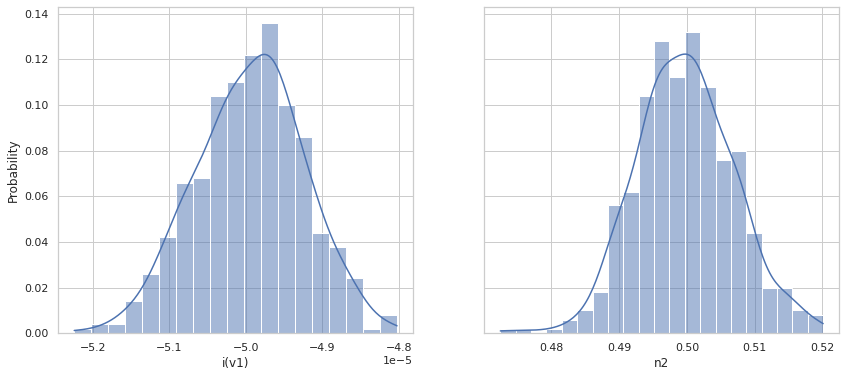

In [9]:
f, axs = plt.subplots(1, 2, figsize=(14,6), sharey=True)
sns.histplot(data=df_out, x="i(v1)", ax=axs[0], stat='probability', kde=True)
_ = sns.histplot(data=df_out, x="n2", ax=axs[1], stat='probability', kde=True)

### Comparison with expected results

In [10]:
sigma_V2_sim = df_out.n2.std()
print("Expected standard deviation on V(n2) = {:.3f}mV".format(sigma_V2*1e3))
print("Simulated standard deviation on V(n2) = {:.3f}mV".format(sigma_V2_sim*1e3))
print("Error = {:.1f}%".format((sigma_V2_sim/sigma_V2 - 1)*100.0))

Expected standard deviation on V(n2) = 7.071mV
Simulated standard deviation on V(n2) = 7.176mV
Error = 1.5%


In [11]:
sigma_I_sim = df_out['i(v1)'].std()
print("Expected standard deviation on I(V1) = {:.3f}uA".format(sigma_I*1e6))
print("Simulated standard deviation on I(V1) = {:.3f}uA".format(sigma_I_sim*1e6))
print("Error = {:.1f}%".format((sigma_I_sim/sigma_I - 1)*100.0))

Expected standard deviation on I(V1) = 0.707uA
Simulated standard deviation on I(V1) = 0.706uA
Error = -0.1%


## Conclusion

We have demonstrated that using the ngspice-connect Python wrapper to ngspice shared library allows to efficiently run a Monte Carlo simulation loop with very little overhead.
Using an example based on a very simple resistive divider netlist, we have seen that the obtained results using the ngspice built-in `agauss` function are consistent with the theoretical results.